# Pvlib example

Example of how to derive PV power production from CAMS radiation data through [pvlib](http://pvlib-python.readthedocs.io/en/latest)

In [1]:
import pandas as pd
import CAMS_radiation_client as cams_client
import pvlib

In [3]:
email = 'your.email@here'

start    = pd.datetime(2017,1,1) # included
end      = pd.datetime(2018,1,1) # excluded
timestep = 1 # minutes

latitude  = 39.867588
longitude = 4.275055
altitude  = 0

In [4]:
client = cams_client.CAMS_Client(email)

cams_df = client.query_radiation_service(start, end, timestep, latitude, longitude)

In [5]:
cams_df.head()

,TOA,Clear_sky_GHI,Clear_sky_BHI,Clear_sky_DHI,Clear_sky_BNI,GHI,BHI,DHI,BNI,Reliability
2017-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2017-01-01 00:01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2017-01-01 00:02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2017-01-01 00:03:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2017-01-01 00:04:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### PV system specs

In [5]:
pv_module_name = 'SolarWorld_Sunmodule_250_Poly__2013_'
inverter_name  = 'ABB__MICRO_0_25_I_OUTD_US_208_208V__CEC_2014_'

In [13]:
# load some module and inverter specifications
sandia_module = pvlib.pvsystem.retrieve_sam('SandiaMod')[pv_module_name]
cec_inverter = pvlib.pvsystem.retrieve_sam('cecinverter')[inverter_name]

# initialize location object
location = pvlib.location.Location(latitude=latitude, longitude=longitude)

# initialize pv system
system = pvlib.pvsystem.PVSystem(surface_tilt=35, surface_azimuth=180,
                                 module_parameters=sandia_module,
                                 inverter_parameters=cec_inverter)

# initialize model chain
mc = pvlib.modelchain.ModelChain(system, location)

### run model 

In [14]:
# cams outputs are in wh, therefore they need to be scaled based on the timestep
weather_df = cams_df[['GHI', 'DHI', 'BNI']].mul(60/timestep).rename(columns={'GHI':'ghi', 'DHI':'dhi', 'BNI':'dni'})

mc.run_model(times=weather_df.index, weather=weather_df)

C:\Users\gbalestrieri\AppData\Local\Continuum\Anaconda3\lib\site-packages\pvlib\pvsystem.py:1463: RuntimeWarning: invalid value encountered in maximum
  spectral_loss = np.maximum(0, np.polyval(am_coeff, airmass_absolute))
C:\Users\gbalestrieri\AppData\Local\Continuum\Anaconda3\lib\site-packages\pvlib\pvsystem.py:1317: RuntimeWarning: divide by zero encountered in log
  module['Voco'] + module['Cells_in_Series']*delta*np.log(Ee) +
C:\Users\gbalestrieri\AppData\Local\Continuum\Anaconda3\lib\site-packages\pvlib\pvsystem.py:1323: RuntimeWarning: divide by zero encountered in log
  module['C3']*module['Cells_in_Series']*((delta*np.log(Ee)) ** 2) +
C:\Users\gbalestrieri\AppData\Local\Continuum\Anaconda3\lib\site-packages\pvlib\pvsystem.py:1324: RuntimeWarning: invalid value encountered in maximum
  Bvmpo*(temp_cell - T0)))
C:\Users\gbalestrieri\AppData\Local\Continuum\Anaconda3\lib\site-packages\pvlib\pvsystem.py:2179: RuntimeWarning: invalid value encountered in minimum
  ac_power = np.min

ModelChain: 
  name: None
  orientation_strategy: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: snlinverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temp_model: sapm_temp
  losses_model: no_extra_losses

In [15]:
ac_power = mc.ac.fillna(0)

In [16]:
# capacity factor (relative to cell DC rated power)
ac_power.mean()/sandia_module[['Vmpo','Impo']].prod()

0.1934143874032994

### Plot

In [17]:
from matplotlib import pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

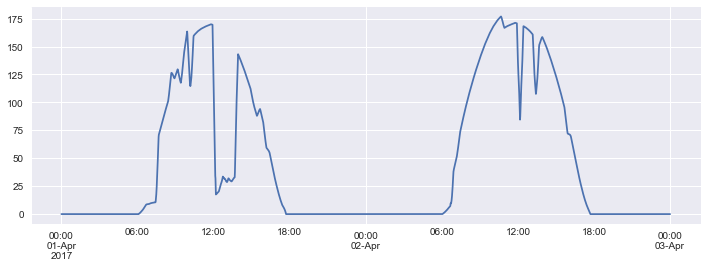

In [18]:
plot_start = pd.datetime(2017,4,1)
plot_end   = pd.datetime(2017,4,3)

ac_power[plot_start:plot_end].plot(figsize=(12,4))

In [1]:
ac_power.diff().abs().max()

NameError: name 'ac_power' is not defined